## Introduction

Washington State University's Decision Aid System as well as others have provided tree fruit growers with population phenology models for the common pest known as codling moth (_Cydia pomonella_) for years which have been shown to be quite reliable, and much research has been done into the population dynamics of codling moth subject to the manipulation various independent variables. One inconsistency relayed to the WSU CAHNRS Dept. of Entomology by growers is a discrepancy in the time our models expect the first emergences of the overwintering generation, and when their traps actually find evidence of them. Some organizations have asserted that these first trap captures are indicitive of the _real_ first emergence times, stating that they should be used as a sort of "biofix" that the models must be translated over to match. The fact that the same growers report significantly better matching in the second and third generations suggests to us that this is not the case, and we hypothesize that it is the result of sampling error that causes the difference in time between first emergence and first capture in these systems. Due to the very monolithic management of real orchards making field data not useful, and the very long turnaround times for new lab data to become available, it has been opted to use a simulation generating data matching key expectations gathered in previous lab studies to investigate the problem. The simulation is used to generate a swathe of data as a convolution of three varying degrees of freedom in the starting conditions (starting population size of the overwintering generation, percentage chance to capture a moth on a given degree day, and the average mating delay experienced by the moths).

## Import libraries and split into individual dataframes for each permutation of variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
df = pd.read_csv('test_1.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

## Compile data about capture-emergence difference and clean instances with no first generation captures and/or first generation emergences

In [2]:
first_capture_data = []
for frame in dfs:
    first_capture = frame[frame.captured > 1].head(1).dd
    first_emergence = frame[(frame.pop_active_0 > 1)].head(1).dd
    if not first_capture.empty and not first_emergence.empty:
        diff = first_capture.iloc[0] - first_emergence.iloc[0]
        pop_0 = frame.head(1).pop_0.iloc[0]
        prob_capture = frame.head(1).prob_capture.iloc[0]
        mating_delay = frame.head(1).mating_delay.iloc[0]
        ratio = (pop_0 ** 1/3) * (prob_capture ** 3)
        first_capture_data.append((diff, ratio, pop_0, prob_capture, mating_delay))

## Organize data into three dataframes, a unified frame, an explanitory varaible frame, and a dependent variable frame

In [3]:
capture_df = pd.DataFrame(first_capture_data, columns=['difference', 'ratio', 'pop_0', 'prob_capture', 'mating_delay'])
df_x = capture_df.drop('difference', axis=1)
df_y = capture_df['difference']

## View variables against each other

<Axes: xlabel='mating_delay', ylabel='difference'>

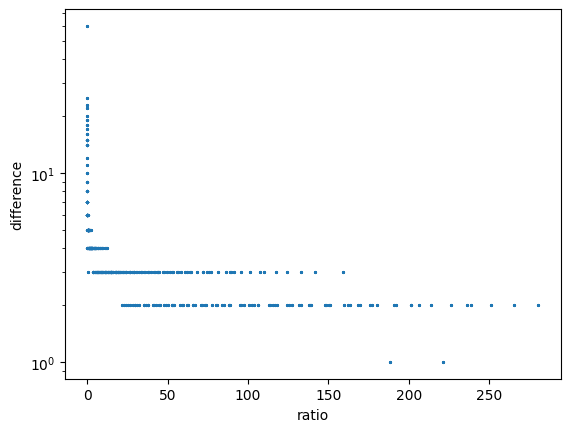

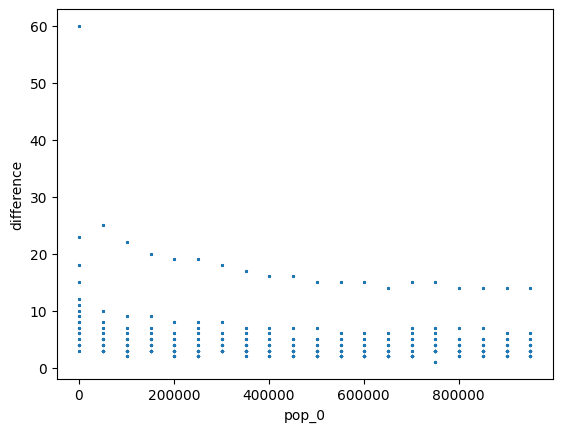

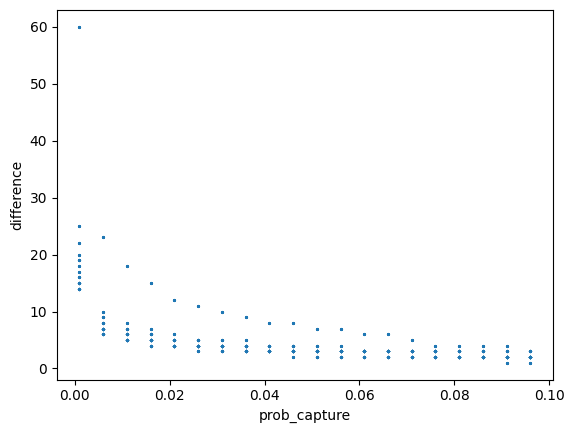

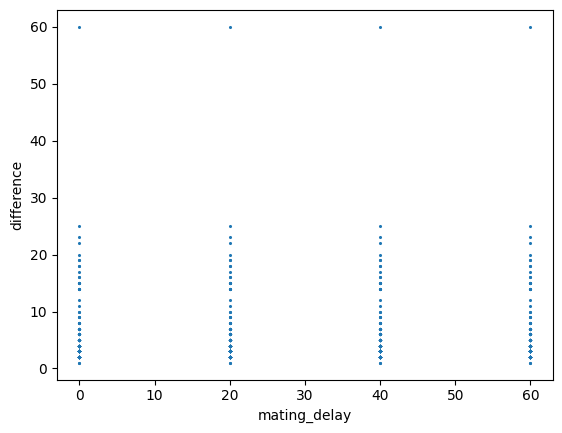

In [4]:
capture_df.plot.scatter(1, 0, 1.5, logy=True)
capture_df.plot.scatter(2, 0, 1.5, logy=False)
capture_df.plot.scatter(3, 0, 1.5, logy=False)
capture_df.plot.scatter(4, 0, 1.5, logy=False)

## Fit curve based on linearization of a reciprocal function ((a/x^c) + b)

1.0003221736931667 -0.0014760595458053244


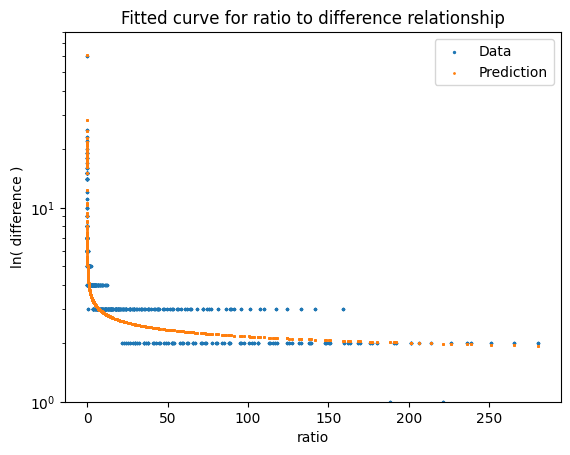

In [36]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    ''' inverse of reciprocal function to fit based on linearity '''
    return np.power(np.multiply(np.reciprocal(np.subtract(x, b)), a), 1 / c)

a = 3.024
b = 0.965
c = 0.2
y = capture_df.difference
y_linear = func(capture_df.difference, a, b, c)
x = capture_df.ratio

p, res, _, _, _ = np.polyfit(x, y_linear, 1, full=True, w=np.log(y))
# x = np.log2(capture_df.ratio)

# popt, pcov = curve_fit(func, x, y, [50, 0.5, 0.3], maxfev=10_000)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log') # view in log to emphasize small differences
ax.set_ylim(1, 80)
ax.set_xlabel('ratio')
ax.legend()
print(*p) # adjust a, b, and c based on how close these values are to a y=x curve

## Determine goodness of fit by looking at residuals

### Residual Plot

Text(0.5, 0, 'ratio')

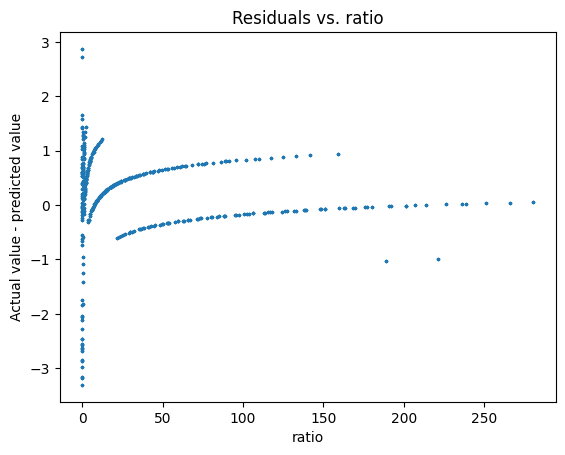

In [38]:
ax = plt.axes()
ax.scatter(x, np.subtract(y, fitted_y), label='Data', s=2)
ax.set_title('Residuals vs. ratio')
ax.set_ylabel('Actual value - predicted value')
ax.set_xlabel('ratio')

Definitely some heteroscedasticity, but it looks like the worst of it is only +/- 3, and the majority of points seem to be in the +/- 1 area.

### Measure how bad the heteroscedasticity is within the unstable small values area

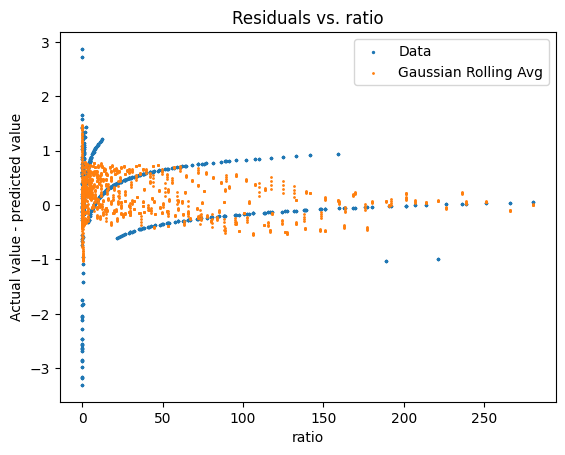

In [46]:
from scipy.ndimage import gaussian_filter1d

rolling_avg = uniform_filter1d(np.subtract(y, fitted_y), 40, mode='nearest')

ax = plt.axes()
ax.scatter(x, np.subtract(y, fitted_y), label='Data', s=2)
ax.scatter(x, rolling_avg, label='Gaussian Rolling Avg', s=1)
ax.set_title('Residuals vs. ratio')
ax.set_ylabel('Actual value - predicted value')
ax.set_xlabel('ratio')
ax.legend()

With a gaussian weighted rolling average with a standard deviation of 50, it does appear the vast majority of all residuals hang within the +/- 1.0 range, which is definitely below noise for field emergences/captures. I am quite satisfied with this, though I do think the ultimate root cause of the heteroscedasticity could probably be weeded out given enough time and the residuals could be made 100% normally distributed. For now, this is well within the bounds of utility.

### Average bias per point

In [35]:
np.sum(np.subtract(y, fitted_y)) / len(x)

0.16036031538870113

The fitted curve is a little biased negative relative to the actual data, but I again feel that less than a fifth of a degree day average negative bias is satisfactory for practical use.